In [18]:
import gcsfs
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scanpy as sc
from scanpy.external.tl import sandbag
import scipy
from scipy import integrate
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
import sys

#local import
import helper_functions_published

In [2]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, format='png') # figsize=[7,7]) facecolor='white', 
fig_dir = 'figures/script4a/'
sc.settings.figdir = fig_dir
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


# Read in reclustered (post QCd) CD138+ anndata object

In [3]:
adata_location = 'outputs/script3.5/cd138_adata_postQC_groundtruthlabeled_leidenresults.h5ad' #replace with your local path to anndata object

In [4]:
cd138_adata = sc.read(adata_location)
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'person', 'age', 'batch', 'sorting_tag', 'disease_stage', 'sex', 'disease_stage_short', 'SAMPLE', 'sample_id', 'Type', 'Gender', 'Age at Dx', 'Diagnosis date', 'Race', 'Type.1', 'FISH 1', 'FISH 1 Date', 'FISH 2', 'FISH 2 Date', 'FISH 3', 'FISH 3 Date', 'FISH 4', 'FISH 4 Date', 'BM at Diagnosis', 'M Protein when sample was taken', 'Date of BM Aspirate used for single-cell RNA Seq', 'Infiltration of Used BM or Aspirate', 'BM Transplant', 'Transplant Date', 'Induction', 'XRT', 'Maintenance Tx', 'Relapse Date', 'Total # cells', 'CD138+', 'CD45+', 'CD45-', 'PMH', 'Family Hx', 'Smoking', 'Alcohol', 'Previous Chemo', 'n_genes', 'percent_mito', 'n_counts', 'possible_doublet', 'S_score', 'G2M_score', 'phase', 'prolif_idx', 'EMT_score', 'leiden', '__is_in_cluster__', 'ground_truth', 'ncells_persample', 'hemoglobin_score', 'person_group', 'sample_purity', 'person_oldnames', 'tx', 'HRD', 'driver event'
    var: 'gene_ids', 'n_cells', 'hig

# Purity model
#### $\kappa_t$ = the proportion of kappa cells among the tumor cells in a sample
#### $\kappa_n$ = the proportion of kappa cells among the normal cells in a sample
#### K = the number of kappa expressing cells in a sample

#### Specifically, we aim to calculate $P(\rho, \kappa_t|K,N)$, where $$P(\rho,\kappa_t|K,N) \propto P(K|\rho,\kappa_t,N)P(\rho,\kappa_t|N)$$ 
#### $$= P(K|\rho,\kappa_t,N)P(\rho)P(\kappa_t) $$
#### $$= P(\rho)P(\kappa_t)\int_0^1 P(K|\rho,\kappa_t,\kappa_n,N)P(\kappa_n)d\kappa_n $$

#### We assume a uniform prior on $\rho$, $$P(\rho|N) = P(\rho) \sim Beta(1,1)$$

#### And that the number of Kappa cells is drawn from a binomial distribution $$P(K | \rho,N,\kappa_t,\kappa_n) \sim Binomial(N,p_l)$$  
#### where $p_l$ is the expected proportion of kappa cells, given kappa and rho 
#### $$p_l= \rho*\kappa_t + (1-\rho)*\kappa_n$$


#### where $\kappa_n \sim Normal(\mu,\sigma^2)$ (fit from healthy donor samples)

### calculate $P(\kappa_n)$:

In [6]:
# assign each cell as "kappa" or "lambda" depending on which Ig it is expressing
kappa_idx = np.where(cd138_adata.var.index == 'IGKC')[0][0]
lambda_idx = np.where(cd138_adata.var.index == 'IGLC2')[0][0]
cell_lightchain_type = pd.DataFrame({'kappa_lognorm':np.array(cd138_adata.layers['lognorm'][:,[kappa_idx]].todense()).squeeze(), 'lambda_lognorm':np.array(cd138_adata.layers['lognorm'][:,[lambda_idx]].todense()).squeeze(), 'disease_stage':cd138_adata.obs.disease_stage, 'sample_id':cd138_adata.obs.person}, index=cd138_adata.obs.index)
cell_lightchain_type['cell_ig'] = np.where(cell_lightchain_type.kappa_lognorm>cell_lightchain_type.lambda_lognorm, 'kappa', 'lambda')
cell_lightchain_type = cell_lightchain_type.assign(kappa_bool=np.where(cell_lightchain_type.cell_ig=='kappa', 1, 0))
cell_lightchain_type

,kappa_lognorm,lambda_lognorm,disease_stage,sample_id,cell_ig,kappa_bool
index,,,,,,
AAACCTGAGGTAAACT-1-MM-5.138P,7.045350,1.130110,MM,MM-5,kappa,1
AAACCTGGTCCCTACT-1-MM-5.138P,6.849931,2.420191,MM,MM-5,kappa,1
AAACCTGGTTACCGAT-1-MM-5.138P,7.053882,0.906211,MM,MM-5,kappa,1
AAACGGGAGCACACAG-1-MM-5.138P,7.427495,1.382221,MM,MM-5,kappa,1
AAACGGGTCACAATGC-1-MM-5.138P,6.364900,2.736315,MM,MM-5,kappa,1
...,...,...,...,...,...,...
TTTCCTCGTTGCCTCT-1-SMMh-3.138P,8.764981,2.743428,SMM,SMM-6,kappa,1
TTTGCGCAGTGGGTTG-1-SMMh-3.138P,9.597503,3.904283,SMM,SMM-6,kappa,1
TTTGCGCCAAGACGTG-1-SMMh-3.138P,8.986351,1.510409,SMM,SMM-6,kappa,1


In [7]:
#calculate $P(\kappa_n)$
frac_kappa = cell_lightchain_type.groupby('sample_id')['kappa_bool'].agg(np.mean)
mean_kappa_normal = frac_kappa[[i for i in frac_kappa.index if 'NBM' in i]].mean()
std_kappa_normal  = frac_kappa[[i for i in frac_kappa.index if 'NBM' in i]].std()

In [8]:
print(mean_kappa_normal)
print(std_kappa_normal)

0.6073402298301359
0.054257427198363684


In [9]:
#variance
std_kappa_normal**2

0.0029438684061857353

In [10]:
#likelihood of observing negative kappa_n
scipy.stats.norm.cdf(x=0, loc=mean_kappa_normal, scale=std_kappa_normal)

2.189397010542347e-29

In [72]:
import importlib
importlib.reload(helper_functions_published)

<module 'helper_functions_published' from '/home/rpeyser/GitHub/mm_singlecell/helper_functions_published.py'>

In [56]:
#calculate probabilities of purities
toplot = pd.DataFrame() #hold probabilities in long form data frame for easy plotting

#predict for pre-treatment bone marrow samples only (exclude AL for now)
for this_sample in cd138_adata.obs.person.cat.categories: 
    rhos, marginals = helper_functions_published.estimate_purity_lc_only(cell_lightchain_type, 'sample_id', this_sample, 
                                                mean_kappa_normal=mean_kappa_normal, std_kappa_normal=std_kappa_normal, rho_granularity=0.01,
                                                a=1, b=1)
    #create long dataframe containing marginal of purity to plot more nicely outside of loop
    toplot = toplot.append(pd.DataFrame({'probability':marginals, 'purity':np.around(rhos, 2), 'sample_id':this_sample, 'title':"Posterior on Purities for Sample " + this_sample}))

In [57]:
toplot = toplot.merge(cd138_adata.obs[['person','disease_stage']].drop_duplicates(), how='left', right_on="person", left_on='sample_id', right_index=False, left_index=False).drop_duplicates()

In [58]:
#order samples by disease stage (useful for visualization)
#order for plotting
toplot.sample_id = pd.Categorical(toplot.sample_id, categories=[
    'NBM-1', 'NBM-2', 'NBM-3', 'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11', 
    'MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4', 'MGUS-5', 'MGUS-6', 
    'SMM-1', 'SMM-2', 'SMM-3', 
    'SMM-4', 'SMM-5', 'SMM-6', 'SMM-7', 'SMM-8', 'SMM-9', 'SMM-10', 'SMM-11', 'SMM-12', 
    'MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8'], ordered=True)

toplot.disease_stage = pd.Categorical(toplot.disease_stage, categories=[
    'NBM', 'MGUS','SMM', 'MM'], ordered=True)

### for response to reviewers: show that prior on kappa_n is similar whether modeled using normal distribution or beta distribution

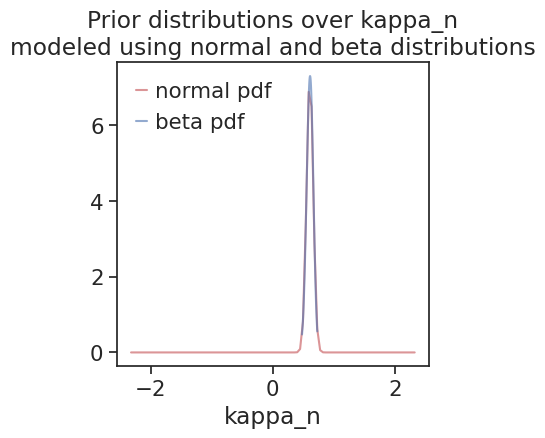

In [84]:
#calculate the parameters a,b of beta distribution that correspond to mean & variance among healthy donors
from scipy.optimize import fsolve
def func(params): #param[0] is a; params[1] is b
    return [params[0]/(params[0]+params[1]) - mean_kappa_normal,
            params[0]*params[1]/((params[0]+params[1])**2*(params[0]+params[1]+1)) - std_kappa_normal**2]
a,b = fsolve(func, [1, 1])

fig, ax = plt.subplots(1, 1)
x = np.linspace(scipy.stats.norm.ppf(0.01),
                scipy.stats.norm.ppf(0.99), 100)
ax.plot(x, scipy.stats.norm.pdf(x, mean_kappa_normal, std_kappa_normal),
       'r-', alpha=0.6, label='normal pdf')

x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)
ax.plot(x, scipy.stats.beta.pdf(x, a, b),
       'b-', alpha=0.6, label='beta pdf')

ax.legend(loc='best', frameon=False)
plt.title("Prior distributions over kappa_n\nmodeled using normal and beta distributions")
ax.set_xlabel("kappa_n")
plt.show()

### calculate 95% confidence interval on purity per sample

In [59]:
def find_conf_interval_puritymodel(df): 
    #takes in df, where df is limited to one person, likely using groupby (the purities should be unique)
    df = df.sort_values('purity')
    idx_beg_95conf_int = np.where(df.probability.cumsum(axis=0) > 0.025)[0][0]
    if idx_beg_95conf_int==100:
        idx_end_95conf_int=100
    else:
        idx_end_95conf_int = np.where(df.probability.cumsum(axis=0) > 0.975)[0][0]-1  
    
    #get purity value
    beg_95conf_int = df.purity.iloc[idx_beg_95conf_int]
    end_95conf_int = df.purity.iloc[idx_end_95conf_int]
        
    return(beg_95conf_int, end_95conf_int)

In [60]:
def find_mode_puritymodel(df):
    #takes in df, where df is limited to one person, likely using groupby (the purities should be unique)
    return(df.purity.iloc[np.argmax(df.probability)]) #return the mode of the distribution (the purity corresponding to greatest prob)

In [61]:
def find_conf_interval_manuallabels(N, n, alpha = 0.95): 
    #given N (total cells) and n (malignant cells), calculates estimate for p, purity
    #based on assumption of beta/binomial conjugate prior
    #alpha gives size of confidence interval 
    return(scipy.stats.beta.interval(alpha, n+1, N-n+1))

#### plot for purity estimates + CI from purity model

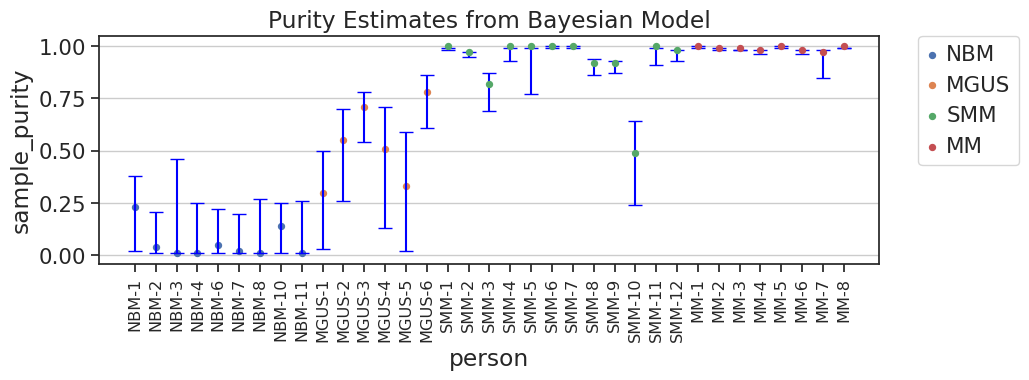

In [62]:
#calc confidence intervals
ci = np.asarray(list(toplot.groupby('person').apply(find_conf_interval_puritymodel))).T #bottom and top of error bar for each sample
lens = (ci[1,:]-ci[0,:])/2 #length of bar
pts = ci[0,:]+lens #midpoint of bar

#find point estimates (mode) from purity model
puritymodel_estimates = pd.DataFrame(toplot.groupby('person').apply(find_mode_puritymodel), columns=["sample_purity"]).merge(cd138_adata.obs[['person','disease_stage']].drop_duplicates(), right_on='person', right_index=False, left_index=True)

plt.figure(figsize=(10, 3))
ax = sns.pointplot(x='person', y='sample_purity', hue='disease_stage', data=puritymodel_estimates.sort_values('person'), linestyles='', scale=.6)
locs, labels = plt.xticks() 
plt.errorbar(locs, pts, lens, linestyle='', capsize=5, ecolor="blue")
plt.xticks(rotation=90, size='x-small')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Purity Estimates from Bayesian Model')
ax.grid(axis='y')

#### plot full purity estimates plot

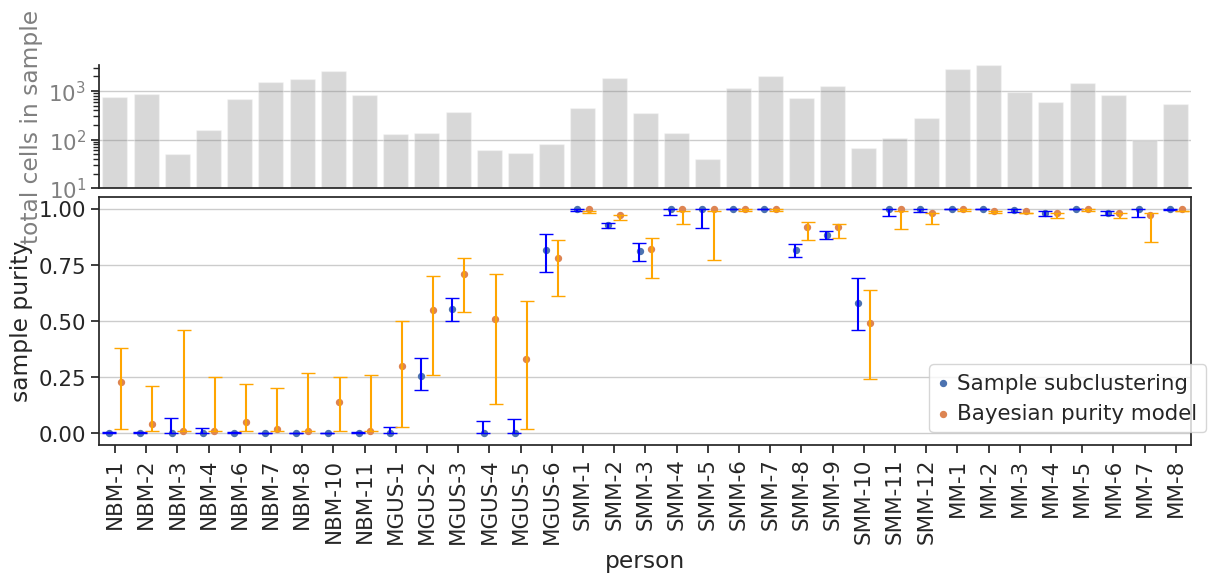

In [63]:
#set up figure
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(14, 5), gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.05)

#### plot all point estimates ####

#prep manual df
manual_estimates = cd138_adata.obs[['person','sample_purity', 'disease_stage']].drop_duplicates().sort_values('person')
manual_estimates['model'] = 'Sample subclustering'

#prep purity model df
puritymodel_estimates = pd.DataFrame(toplot.groupby('sample_id').apply(find_mode_puritymodel), columns=["sample_purity"]).merge(cd138_adata.obs[['person','disease_stage']].drop_duplicates(), right_on='person', right_index=False, left_index=True)
puritymodel_estimates['model'] = 'Bayesian purity model'

# join using append and plot with offset (dodge)
offset = 0.375 #play around with this till the dots lie on the lines
sns.pointplot(x='person', y='sample_purity', hue='model', data=manual_estimates.append(puritymodel_estimates).sort_values('person'), dodge=offset, linestyles='', scale=.6, ax=ax1)

#### plot manual labeling confidence intervals ####

#calculate confidence intervals
num_malig_cells = cd138_adata.obs[cd138_adata.obs.ground_truth=="malignant"].groupby('person').size()
total_cells = cd138_adata.obs[['person','ncells_persample']].drop_duplicates().sort_values('person').set_index('person').ncells_persample
assert(np.all(num_malig_cells.index == total_cells.index))
manual_labels_ci = pd.DataFrame(index=num_malig_cells.index, columns=['beg_interval', 'end_interval']) #initialize data frame

for person in num_malig_cells.index:
    beg_range, end_range = find_conf_interval_manuallabels(total_cells.loc[person], num_malig_cells.loc[person])
    manual_labels_ci.loc[person] = [beg_range, end_range]
    
lens = (manual_labels_ci.iloc[:,1]-manual_labels_ci.iloc[:,0])/2 #length of bar
pts = manual_labels_ci.iloc[:,0]+lens #midpoint of bar

#offset error bars to left of xtick
locs, labels = plt.xticks() 
locs = locs-0.2

ax1.errorbar(locs, pts, lens, linestyle='', capsize=5, ecolor="blue")

#### plot purity model confidence intervals ####

#calc confidence intervals
ci = np.asarray(list(toplot.groupby('person').apply(find_conf_interval_puritymodel))).T #bottom and top of error bar for each sample
lens = (ci[1,:]-ci[0,:])/2 #length of bar
pts = ci[0,:]+lens #midpoint of bar

locs, labels = plt.xticks() 
locs=locs+0.2
ax1.errorbar(locs, pts, lens, linestyle='', capsize=5, ecolor="orange")

#### plot ncells ####
#ax2 = plt.axes() #ax1.twinx()  # instantiate a second axes that shares the same x-axis
#set ax2 to sit atop the plot
#ax2_pos = np.array(ax1.get_position())
#ax2_pos[:,1]+=np.array(ax1.get_position())[1,1]
#ax2.set_position(matplotlib.transforms.Bbox(ax2_pos))
ax2_color='grey'
#color by disease stage:sns.barplot(x='person', y='scaled', hue='disease_stage', dodge=False, data = cd138_adata.obs[['person','ncells_persample', 'disease_stage']].drop_duplicates().sort_values('person').assign(scaled=lambda df: df['ncells_persample']/np.max(df['ncells_persample'])), ax=ax2, alpha=0.5)
sns.barplot(x='person', y='ncells_persample', color=ax2_color, dodge=False, data = cd138_adata.obs[['person','ncells_persample', 'disease_stage']].drop_duplicates().sort_values('person'), ax=ax2, alpha=0.3)

#### random formatting stuff ####
## axis 1
ax1.tick_params(labelrotation=90, axis='x')
ax1.set_ylabel("sample purity")
ax1.legend(loc="lower left", bbox_to_anchor=(0.76, 0.05), borderaxespad=0.)
ax1.grid(b=True, which='major', axis='y')
ax1.set_yticks([0,.25,.5,.75,1]);
#ax1.set_ylim(-0.05, 1.05) #where should axis start and end, 0-1 correspond to bottom and top of plotted points I think
#ax1.tick_params()
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

## axis 2
ax2.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yscale("log")
ax2.grid(b=True, which='major', axis='y')
ax2.set_ylabel("total cells in sample", color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color)
#ax2.legend(bbox_to_anchor=(1.1, 0.7), loc=2, borderaxespad=0.)
ax2.set_ylim(10, 3500)


plt.savefig(fig_dir + "purity_results_ALL_withn.png", bbox_inches="tight")
plt.savefig(fig_dir + "purity_results_ALL_withn.pdf", bbox_inches="tight")

/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


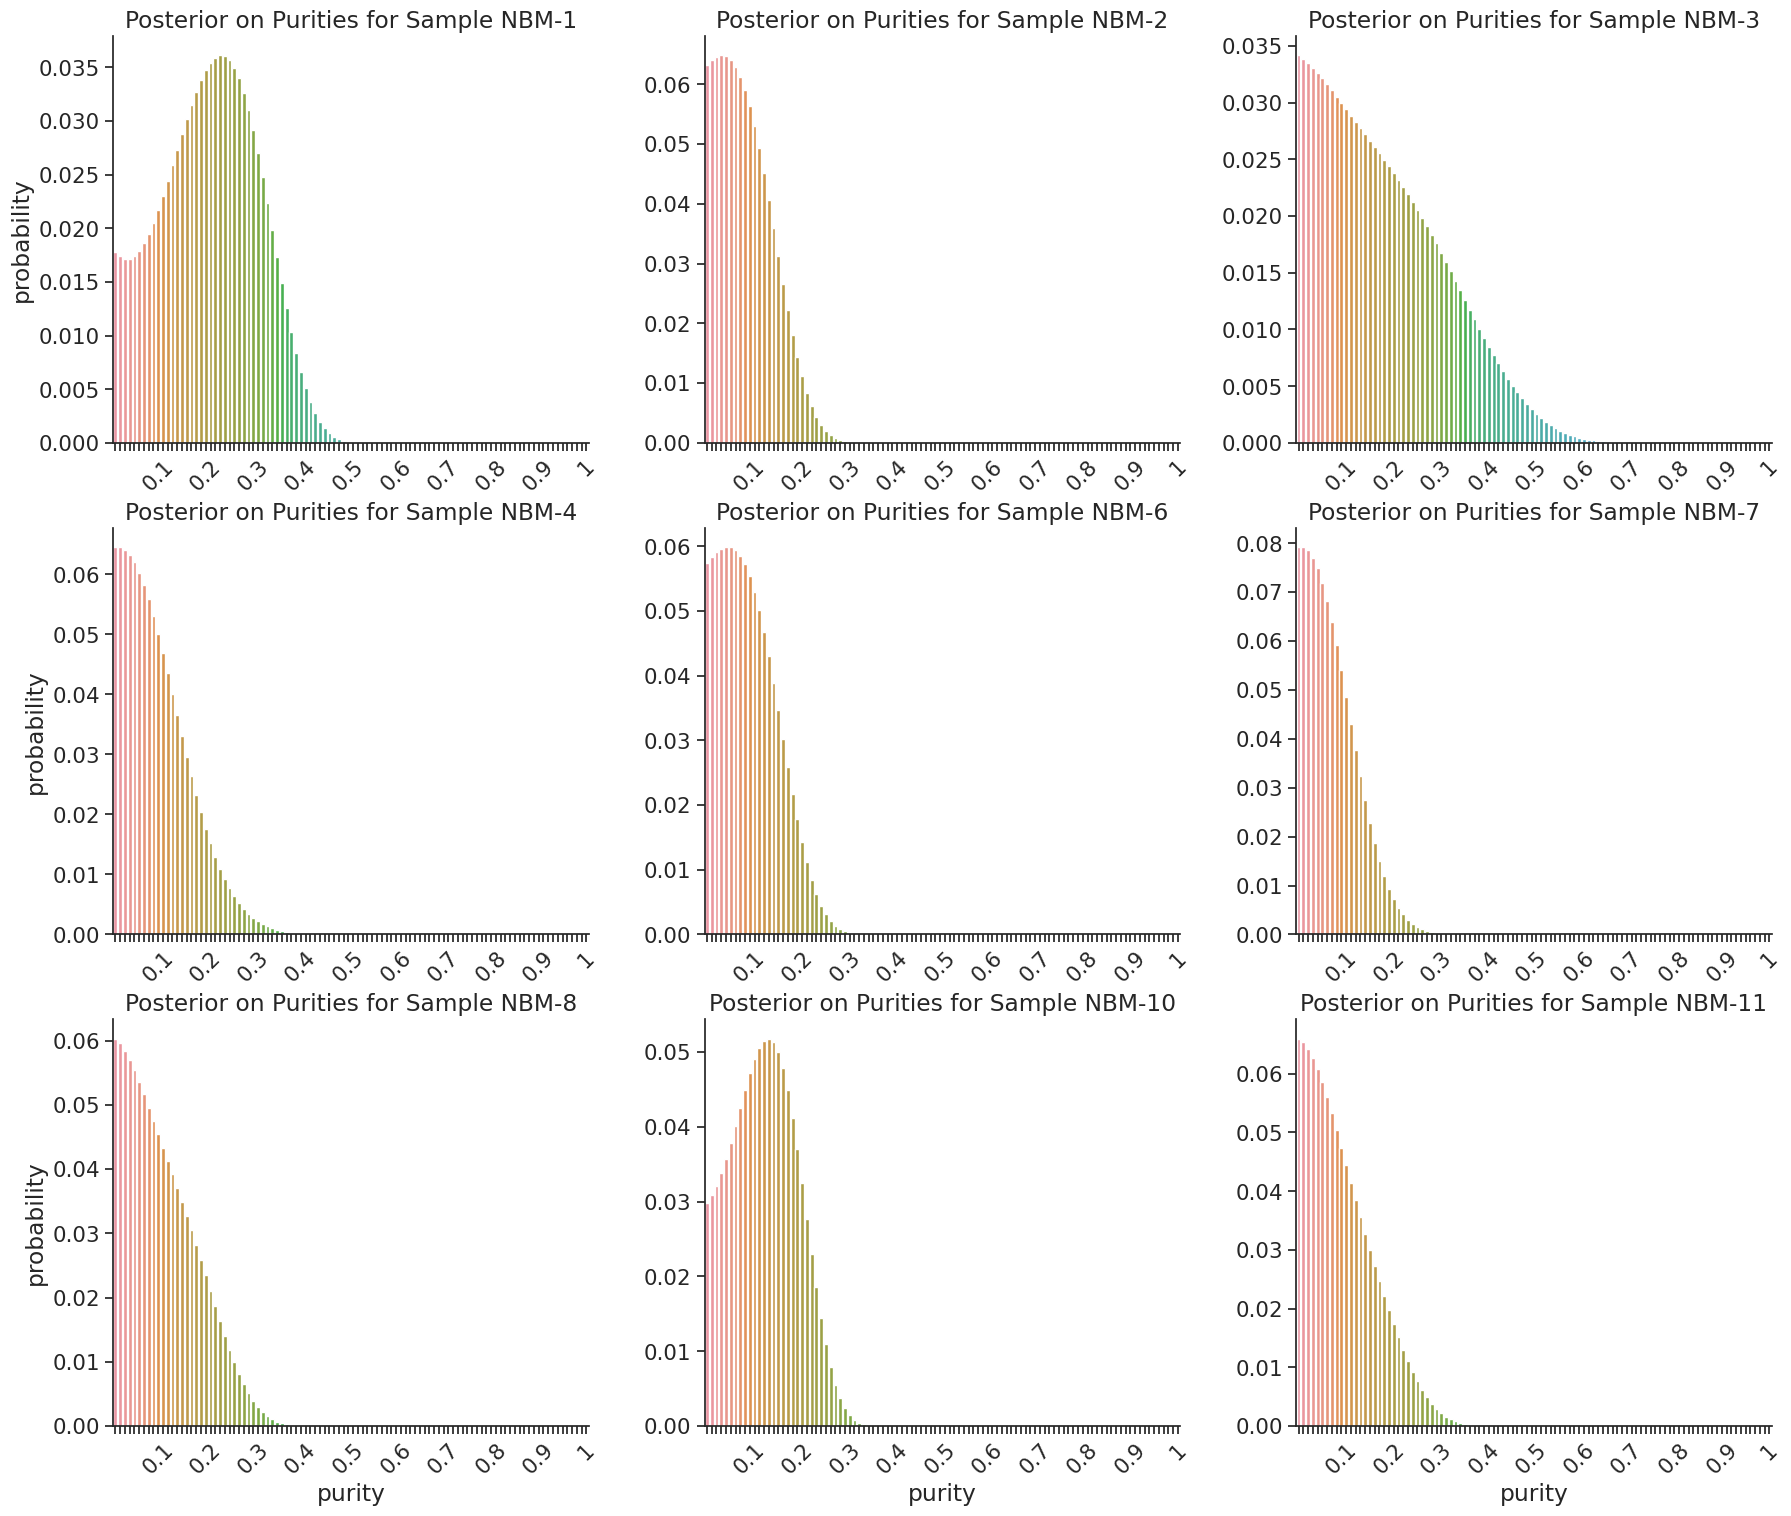

In [66]:
sns.set_theme(style="ticks", font_scale=1.4)
g=sns.catplot(data=toplot.loc[toplot['disease_stage']=='NBM',:], x="purity", y="probability", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False, aspect=1.2)
g.set_titles('{col_name}')
g.set(ylim=(0, None))
xticklabels = [""]*9+[0.1]+[""]*9+[0.2]+[""]*9+[0.3]+[""]*9+[0.4]+[""]*9+[0.5]+[""]*9+[0.6]+[""]*9+[0.7]+[""]*9+[0.8]+[""]*9+[0.9]+[""]*9+[1] #set all labels except 0.1 to empty string
g.set_xticklabels(xticklabels, rotation=45); 
plt.savefig("figures/script4/posteriors_in_NBM.pdf", bbox_inches="tight")

/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


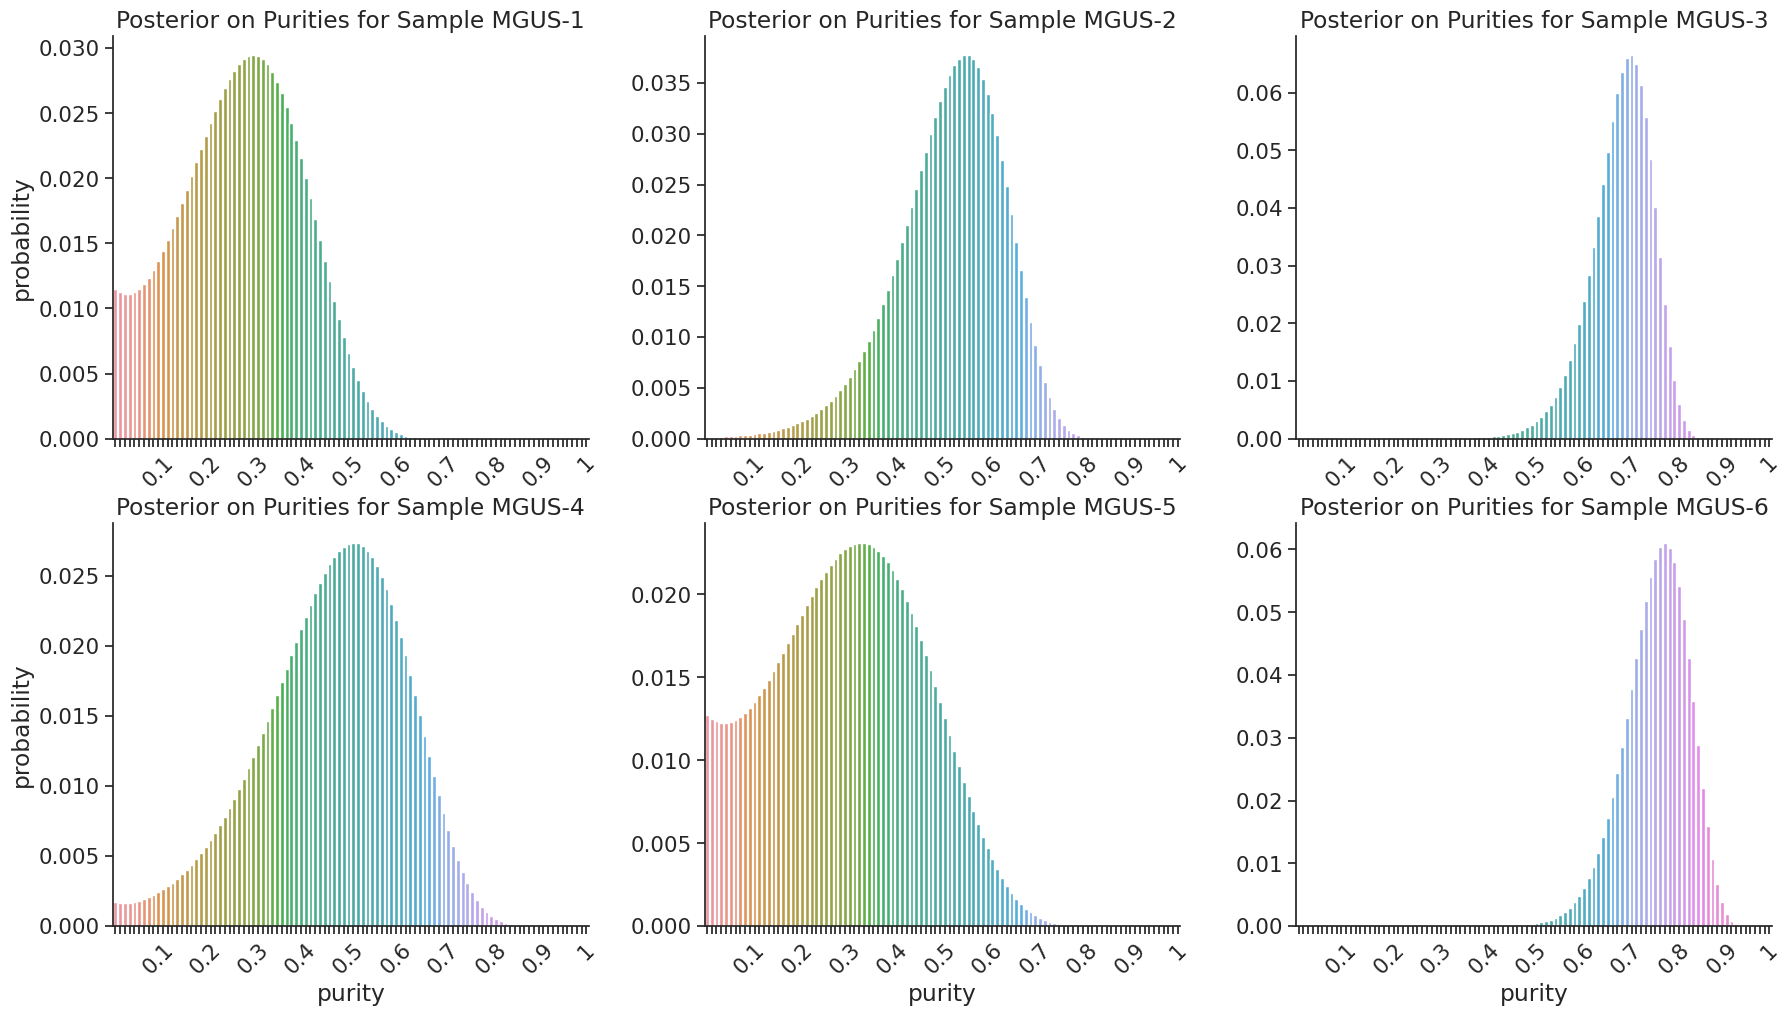

In [67]:
sns.set_theme(style="ticks", font_scale=1.4)
g=sns.catplot(data=toplot.loc[toplot.disease_stage=="MGUS",:], x="purity", y="probability", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False, aspect=1.2) #.loc[np.isin(toplot['person'],['MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4']),:]
g.set_titles('{col_name}')
g.set(ylim=(0, None))
#plt.subplots_adjust(top=0.9)
xticklabels = [""]*9+[0.1]+[""]*9+[0.2]+[""]*9+[0.3]+[""]*9+[0.4]+[""]*9+[0.5]+[""]*9+[0.6]+[""]*9+[0.7]+[""]*9+[0.8]+[""]*9+[0.9]+[""]*9+[1] #set all labels except 0.1 to empty string
g.set_xticklabels(xticklabels, rotation=45); 
plt.savefig("figures/script4/posteriors_MGUS.pdf", bbox_inches="tight")

In [ ]:
sns.set_theme(style="ticks", font_scale=1.4)
g=sns.catplot(data=toplot.loc[toplot.disease_stage=="SMMl",:], x="purity", y="probability", col="title", col_wrap=2, kind="bar", sharex=False, sharey=False, aspect=1.2) #.loc[np.isin(toplot['person'],['MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4']),:]
g.set_titles('{col_name}')
g.set(ylim=(0, None))
#plt.subplots_adjust(top=0.9)
xticklabels = [""]*9+[0.1]+[""]*9+[0.2]+[""]*9+[0.3]+[""]*9+[0.4]+[""]*9+[0.5]+[""]*9+[0.6]+[""]*9+[0.7]+[""]*9+[0.8]+[""]*9+[0.9]+[""]*9+[1] #set all labels except 0.1 to empty string
g.set_xticklabels(xticklabels, rotation=45); 
plt.savefig("figures/script4/posteriors_SMMh.pdf", bbox_inches="tight")

In [ ]:
sns.set_theme(style="ticks", font_scale=1.4)
g=sns.catplot(data=toplot.loc[toplot.disease_stage=="SMMh",:], x="purity", y="probability", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False, aspect=1.2) #.loc[np.isin(toplot['person'],['MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4']),:]
g.set_titles('{col_name}')
g.set(ylim=(0, None))
#plt.subplots_adjust(top=0.9)
xticklabels = [""]*9+[0.1]+[""]*9+[0.2]+[""]*9+[0.3]+[""]*9+[0.4]+[""]*9+[0.5]+[""]*9+[0.6]+[""]*9+[0.7]+[""]*9+[0.8]+[""]*9+[0.9]+[""]*9+[1] #set all labels except 0.1 to empty string
g.set_xticklabels(xticklabels, rotation=45); 
plt.savefig("figures/script4/posteriors_SMMh.pdf", bbox_inches="tight")

In [ ]:
#sns.set_theme(style="ticks", font_scale=1.4)

g=sns.catplot(data=toplot.loc[toplot['disease_stage']=='MM',:], x="purity", y="probability", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False, aspect=1.2)
g.set_titles('{col_name}')
g.set(ylim=(0, None))
#g.axes[1].set_ylim(0,2e-14)
#plt.subplots_adjust(top=0.9)
xticklabels = [""]*9+[0.1]+[""]*9+[0.2]+[""]*9+[0.3]+[""]*9+[0.4]+[""]*9+[0.5]+[""]*9+[0.6]+[""]*9+[0.7]+[""]*9+[0.8]+[""]*9+[0.9]+[""]*9+[1] #set all labels except 0.1 to empty string
g.set_xticklabels(xticklabels, rotation=45); 
plt.savefig("figures/script4/posteriors_in_MM.pdf", bbox_inches="tight")

# show validation of ground truth labels using cytogenetics

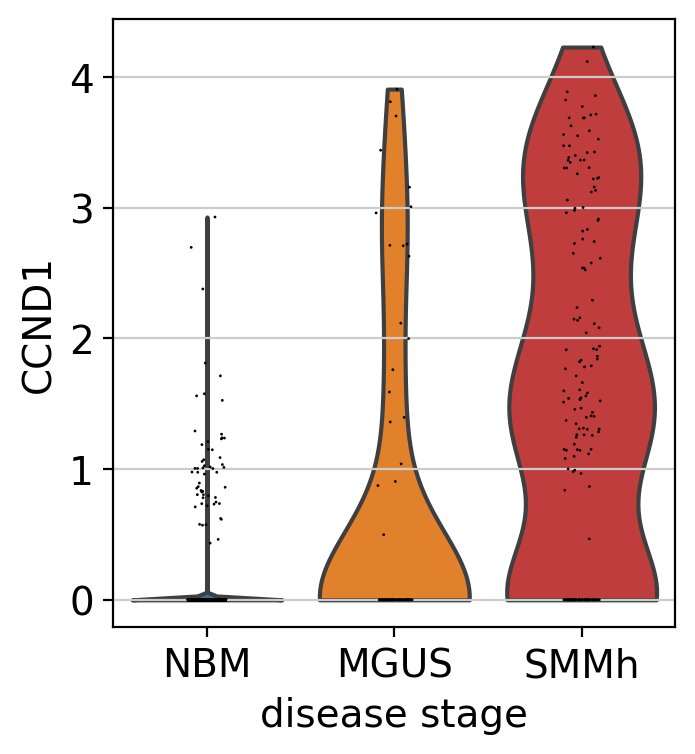

In [9]:
#NBM & cells I labeled as 'healthy plasma' from patients with t(11;14)
#ideally, distribution of CCND1 expression in healthy cells from MGUS & SMMh would be similar to that for NBM

sc.pl.violin(cd138_adata[(cd138_adata.obs.ground_truth=='healthy plasma')&((cd138_adata.obs.disease_stage=='NBM') | (cd138_adata.obs.person.isin(['MGUS-2', 'MGUS-6', 'SMMh-1', 'SMMh-3', 'SMMh-6', 'SMMh-10'])))], 'CCND1', groupby='disease_stage')

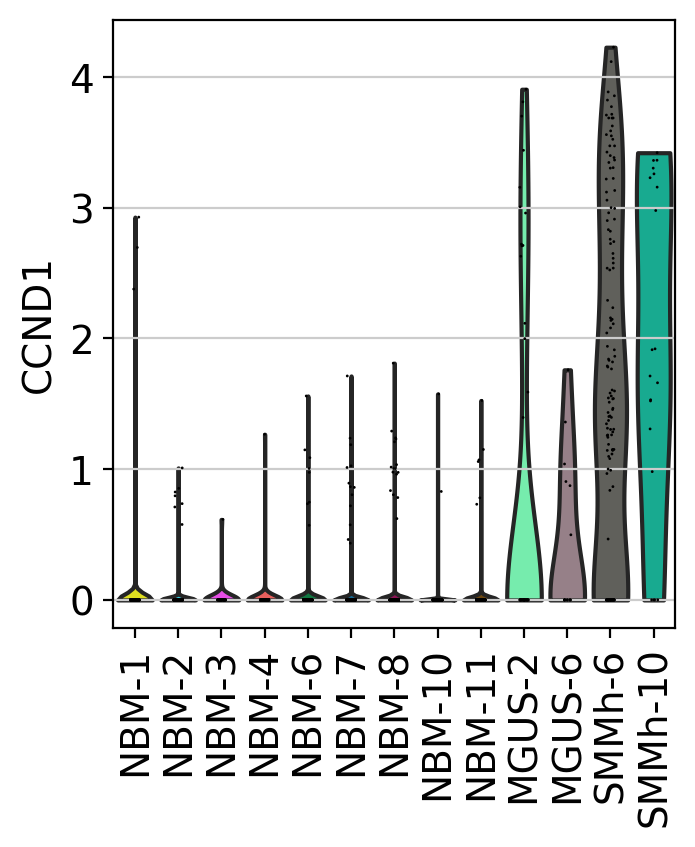

In [13]:
#NBM & cells I labeled as 'healthy plasma' from patients with t(4;14)
#ideally, distribution of CCND1 expression in healthy cells from MGUS & SMMh would be similar to that for NBM

sc.pl.violin(cd138_adata[(cd138_adata.obs.ground_truth=='healthy plasma')&((cd138_adata.obs.disease_stage=='NBM') | (cd138_adata.obs.person.isin(['MGUS-2', 'MGUS-6', 'SMMh-1', 'SMMh-3', 'SMMh-6', 'SMMh-10'])))], 'CCND1', groupby='person', rotation=90)

MGUS-2


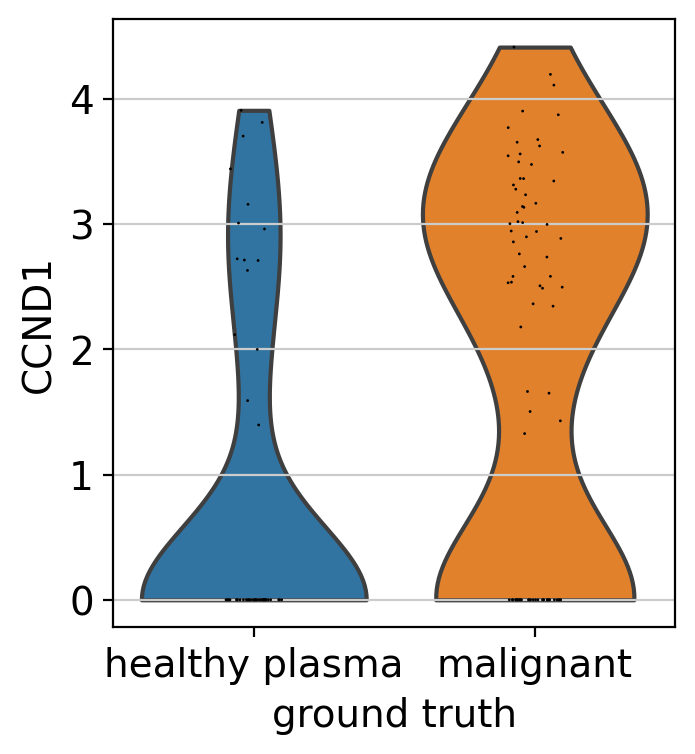

MGUS-6


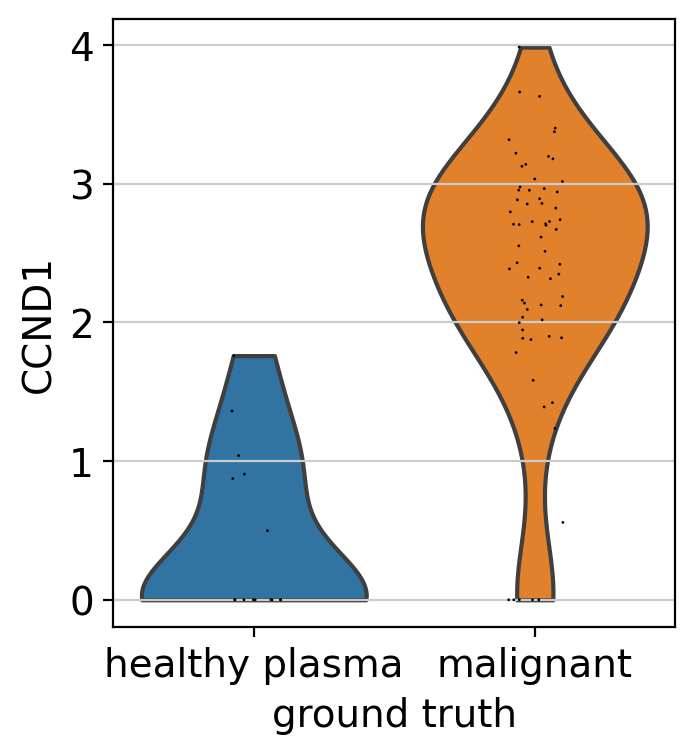

SMMh-1


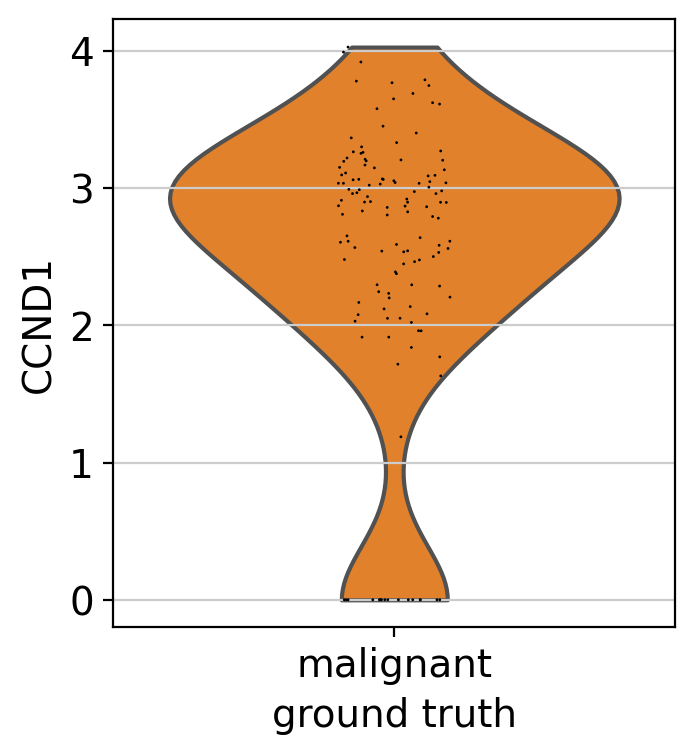

SMMh-3


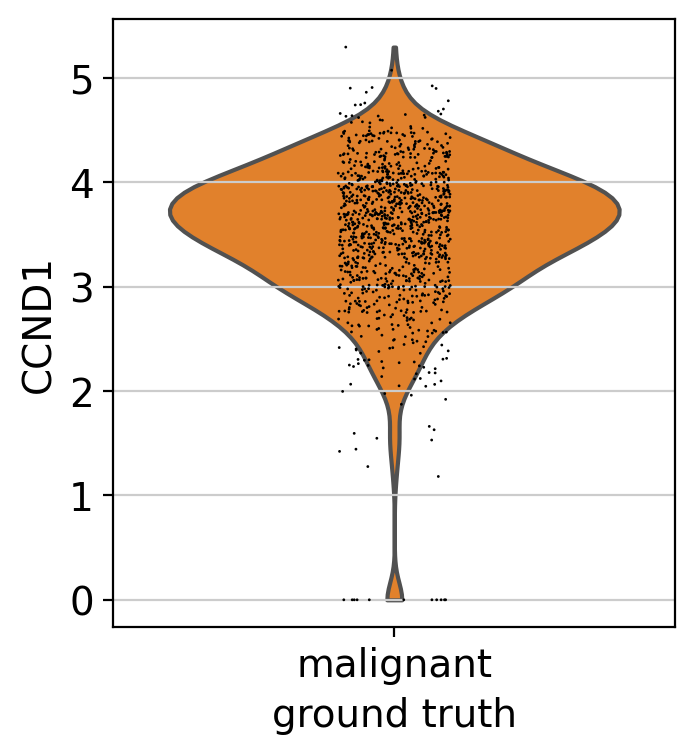

SMMh-6


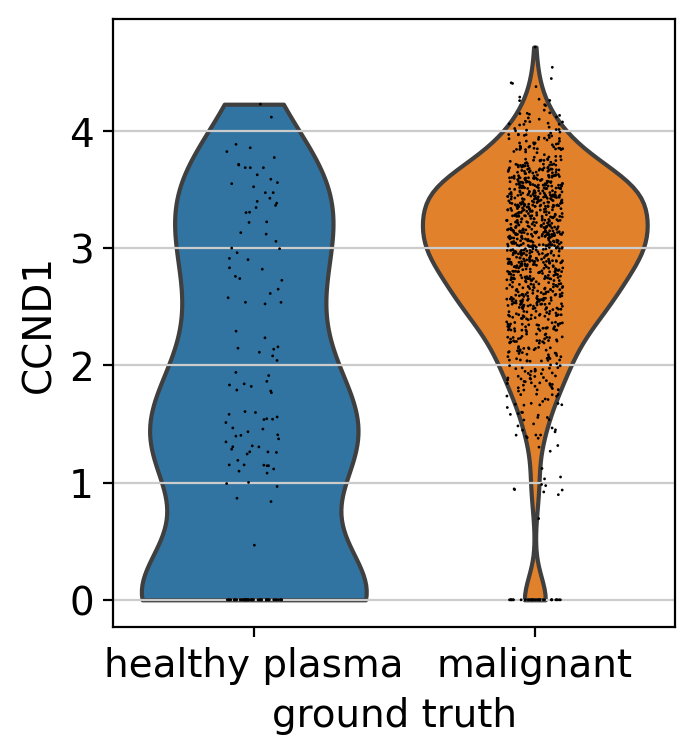

SMMh-10


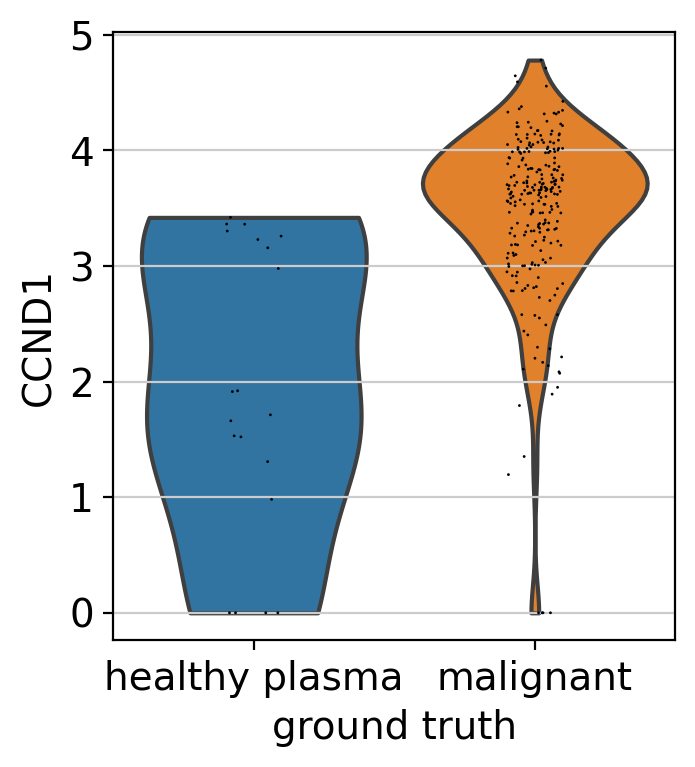

In [10]:
for person in ['MGUS-2', 'MGUS-6', 'SMMh-1', 'SMMh-3', 'SMMh-6', 'SMMh-10']:
    print(person)
    sc.pl.violin(cd138_adata[cd138_adata.obs.person==person], 'CCND1', groupby='ground_truth')